In [1]:
# https://github.com/OceanParcels/GlobalMassBudget/blob/main/create_masks_NEMO0083.py

In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from datetime import timedelta,datetime
import xarray as xr
import pandas as pd
import matplotlib
from argparse import ArgumentParser


In [5]:
def NEMO_select_section(extent,lon,lat,val):
    
    lon_mean = .5*(extent[0]+extent[1])
    lat_mean = .5*(extent[2]+extent[3])
    
    i_min = np.unravel_index( (np.sqrt( (lon-lon_mean)**2 + (lat-lat_mean)**2   )).argmin() , lon.shape)
    
    i_lon_s = np.where(  (lon[i_min[0],:] > extent[0]) & (lon[i_min[0],:] < extent[1]) )[0][0]
    i_lon_e = np.where(  (lon[i_min[0],:] > extent[0]) & (lon[i_min[0],:] < extent[1]) )[0][-1]

    i_lat_s = np.where(  (lat[:,i_min[1]] > extent[2]) & (lat[:,i_min[1]] < extent[3]) )[0][0]
    i_lat_e = np.where(  (lat[:,i_min[1]] > extent[2]) & (lat[:,i_min[1]] < extent[3]) )[0][-1]
    
    return lon[i_lat_s:i_lat_e,i_lon_s:i_lon_e], lat[i_lat_s:i_lat_e,i_lon_s:i_lon_e], val[i_lat_s:i_lat_e,i_lon_s:i_lon_e]
    
def to_netcdf(output_filename,data,data_name,lons,lats,explanation=''):
    '''
    All data is written to netcdf files to speed up computations
    '''
    
    dict_data = {}
    for data_, name_ in zip(data,data_name):
        dict_data[name_] = (["x","y"], data_)
    dict_data['explanation'] = explanation
        
    dict_coords = {}
    dict_coords['lon'] = (["x","y"], lons)
    dict_coords['lat'] = (["x","y"], lats)   
  
    ds = xr.Dataset(
        dict_data,
        coords=dict_coords,
    )   
    ds.to_netcdf(output_filename)


def get_mask_land(field, lons, lats, outfile='./tmp_mask_land'):
    '''
    Mask with true on land cells, false on ocean cells
    '''
    if os.path.exists(outfile):
        ds = xr.open_dataset(outfile)
        mask_land = np.array(ds['mask_land'],dtype=bool)    
    else:
        mask_land = np.isnan(field)
        to_netcdf(outfile,[mask_land],['mask_land'],lons,lats,explanation='land mask')
    return mask_land

def get_shore_nodes(landmask):
    """Function that detects the shore nodes, i.e. the land nodes directly
    next to the ocean. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

def get_shore_nodes_diagonal(landmask):
    """Function that detects the shore nodes, i.e. the land nodes where 
    one of the 8 nearest nodes is ocean. Computes the Laplacian of landmask 
    and the Laplacian of the 45 degree rotated landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap += np.roll(landmask, (-1,1), axis=(0,1)) + np.roll(landmask, (1, 1), axis=(0,1))
    mask_lap += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (1, -1), axis=(0,1))
    mask_lap -= 8*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore


def create_displacement_field(landmask, lons, lats, double_cell=False, outfile='./tmp_mask_coast'):
    """Function that creates a displacement field 1 m/s away from the shore.

    - landmask: the land mask dUilt using `make_landmask`.
    - double_cell: Boolean for determining if you want a double cell.
      Default set to False.

    Output: two 2D arrays, one for each camponent of the velocity.
    """
    
    if os.path.exists(outfile):
        ds = xr.open_dataset(outfile)
        v_x = np.array(ds['land_current_u'],dtype=float)    
        v_y = np.array(ds['land_current_v'],dtype=float)   
    
    else:
        shore = get_shore_nodes(landmask)
        shore_d = get_shore_nodes_diagonal(landmask) # bordering ocean directly and diagonally
        shore_c = shore_d - shore                    # corner nodes that only border ocean diagonally
        
        Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0) # Simple derivative
        Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
        
        Ly_c = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
        Ly_c += np.roll(landmask, (-1,-1), axis=(0,1)) + np.roll(landmask, (-1,1), axis=(0,1)) # Include y-component of diagonal neighbours
        Ly_c += - np.roll(landmask, (1,-1), axis=(0,1)) - np.roll(landmask, (1,1), axis=(0,1))
        
        Lx_c = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
        Lx_c += np.roll(landmask, (-1,-1), axis=(1,0)) + np.roll(landmask, (-1,1), axis=(1,0)) # Include x-component of diagonal neighbours
        Lx_c += - np.roll(landmask, (1,-1), axis=(1,0)) - np.roll(landmask, (1,1), axis=(1,0))
        
        v_x = -Lx*(shore)
        v_y = -Ly*(shore)
        
        v_x_c = -Lx_c*(shore_c)
        v_y_c = -Ly_c*(shore_c)
        
        v_x = v_x + v_x_c
        v_y = v_y + v_y_c
    
        magnitude = np.sqrt(v_y**2 + v_x**2)
        # the coastal nodes between land create a problem. Magnitude there is zero
        # I force it to be 1 to avoid problems when normalizing.
        ny, nx = np.where(magnitude == 0)
        magnitude[ny, nx] = 1
    
        v_x = v_x/magnitude
        v_y = v_y/magnitude

        to_netcdf(outfile,[v_x,v_y],['land_current_u','land_current_v'],lons,lats,explanation='land current, pusing particles on land back to the sea, magnitude of 1')
    return v_x, v_y

In [3]:
data_T = xr.open_dataset('../../data/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-01-09.nc')
data_grid = xr.open_dataset('../../data/input_data/MOi/domain_ORCA0083-N006/coordinates.nc',decode_times=False)

sst = data_T['votemper'].values[0,:,:] # Take top level of temperature dataset
lons = data_grid['nav_lon'][:,:].values
lats = data_grid['nav_lat'][:,:].values

In [4]:
mask_land = get_mask_land(sst, lons, lats, outfile='../../data/output_data/masks/mask_land_NEMO0083.nc')

In [6]:
v_x, v_y = create_displacement_field(mask_land*1, lons, lats, outfile='../../data/output_data/masks/land_current_NEMO0083.nc')

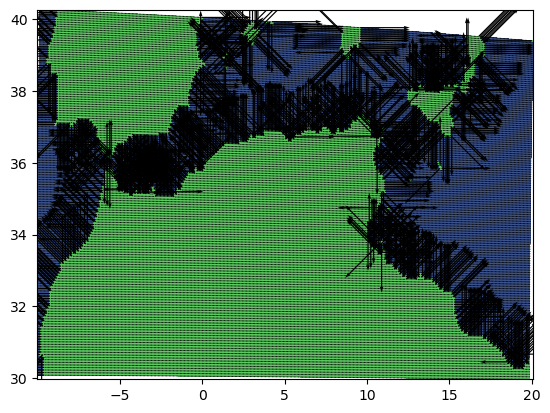

In [7]:
extent = [-10,20,30,40]
X_,Y_,mask_land_ = NEMO_select_section(extent,lons,lats,mask_land)
X_,Y_,v_x_ = NEMO_select_section(extent,lons,lats,v_x)
X_,Y_,v_y_ = NEMO_select_section(extent,lons,lats,v_y)

plt.figure()
plt.contourf(X_,Y_,mask_land_)
plt.quiver(X_,Y_,v_x_,v_y_,scale=10)